In [13]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix, lil_matrix
from scipy.special import gamma
import matplotlib.pyplot as plt
from findiff import FinDiff, Identity, PDE, BoundaryConditions

In [14]:
def operator_to_matrix(diff_op, shape):
    """
    Convert a findiff operator into a precision matrix
    """
    mat = lil_matrix(diff_op.matrix(shape))
    interior_idxs = get_interior_indices(shape)
    mat = mat[interior_idxs]
    mat = mat[:, interior_idxs]
    mat = csr_matrix(mat)
    return mat

def get_domain_indices(shape):
    """
    Get grid indices
    """
    siz = np.prod(shape)
    full_indices = np.array(list(range(siz))).reshape(shape)
    return full_indices


def get_interior_indices(shape):
    """
    Get indices for domain interior
    """
    full_indices = get_domain_indices(shape)
    interior_slice = tuple(slice(1,-1) for _ in range(len(shape)))
    interior_indices = full_indices[interior_slice].flatten()
    return interior_indices

Consider data generated from the SPDE

$$
(\kappa^2 - \Delta)^{\nu/2 + d/4}u = \mathcal{W},
$$

with Dirichlet boundary condition, where $\kappa = \sqrt{2\nu}/l$ and $\mathcal{W}$ is a Gaussian white noise process ($GP(0, \delta(x-y))$) with amplitude $\sigma\sqrt{q}$ for

$$
q = \frac{(4\pi)^{d/2}\kappa^{2\nu}\Gamma(\nu+d/2)}{\Gamma(\nu)}.
$$

We note that this is equivalent to a d-dimensional Matern Gaussian process with smoothness parameter $\nu$ and lengthscale $l$.

In particular, we choose $\nu=1$ and $d=2$, which boils down to a 2D Helmholtz equation.

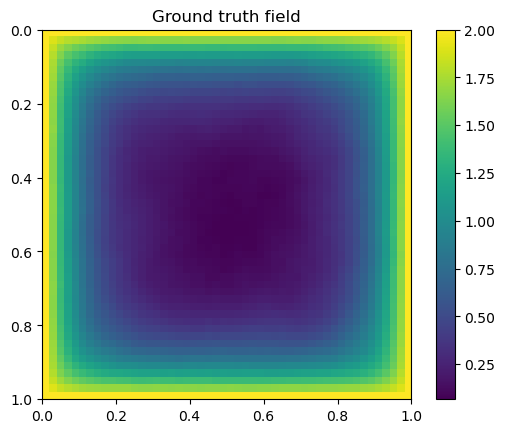

In [15]:
# Generate data from stochastic Helmholtz equation
d = 2
ls = 0.15
nu = 1
amp = 1.1
kappa = np.sqrt(2*nu) / ls
q = ((4*np.pi)**(d/2)*kappa**(2*nu)*gamma(nu+d/2))/gamma(nu)
grid_size = 50

x = y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y, indexing='ij')
X_test = np.stack([X.flatten(), Y.flatten()], axis=1)

shape = (grid_size, grid_size)
dx = x[1]-x[0]
dy = y[1]-y[0]

# Set LHS
diff_op = kappa**2 * Identity() - FinDiff(0, dx, 2) - FinDiff(1, dy, 2)

# Set RHS
np.random.seed(13)
W = (dx*dy)**(-0.5) * np.sqrt(q) * amp * np.random.randn(*shape)

# Set boundary conditions (zero-Dirichlet)
bc = BoundaryConditions(shape)
bc[0, :] = 2
bc[-1,:] = 2
bc[:, 0] = 2
bc[:, -1] = 2

# Solve PDE
pde = PDE(diff_op, W, bc)
u = pde.solve()

# Plot solution
plt.imshow(u, extent=[0,1,1,0])
plt.colorbar()
plt.title('Ground truth field')
plt.show()


In [16]:
num_obs = 200
obs_noise = 1e-4

# Get observations at random locations
rng = np.random.default_rng(0)
x_idxs = y_idxs = np.arange(grid_size)
X_idxs, Y_idxs = np.meshgrid(x_idxs[1:-1], y_idxs[1:-1], indexing='ij')
all_idxs = np.stack([X_idxs.flatten(), Y_idxs.flatten()], axis=1)
idxs = rng.choice(all_idxs, num_obs, replace=False)
obs_dict = {tuple(idx): u[tuple(idx)]+obs_noise*np.random.randn() for idx in idxs}


In [17]:
# Construct precision matrix corresponding to the linear differential operator
mat = operator_to_matrix(diff_op, shape)
prior_precision = (dx * dy) * mat.T @ mat

# Compute posterior mean and covariance
N = np.prod(shape)
interior_idxs = get_interior_indices(shape)
grid_indices = get_domain_indices(shape)

mask = np.zeros(N)
for idx in idxs:
    mask[grid_indices[tuple(idx)]] = 1
posterior_precision = prior_precision + csr_matrix(obs_noise**(-2) * np.diag(mask[interior_idxs]))
posterior_shift = np.zeros(np.prod(shape))
for idx in idxs:
    posterior_shift[grid_indices[tuple(idx)]] = obs_dict[tuple(idx)]/obs_noise**2
posterior_shift = posterior_shift[interior_idxs]
posterior_shift = csr_matrix(posterior_shift).T

posterior_mean_interior = scipy.sparse.linalg.spsolve(posterior_precision, posterior_shift)
posterior_cov_interior = scipy.sparse.linalg.inv(posterior_precision)

posterior_mean = np.zeros(N)
posterior_mean[interior_idxs] = posterior_mean_interior
posterior_mean = posterior_mean.reshape(shape)

posterior_std = np.zeros(N)
posterior_std[interior_idxs] = np.sqrt(posterior_cov_interior.diagonal())
posterior_std = posterior_std.reshape(shape)

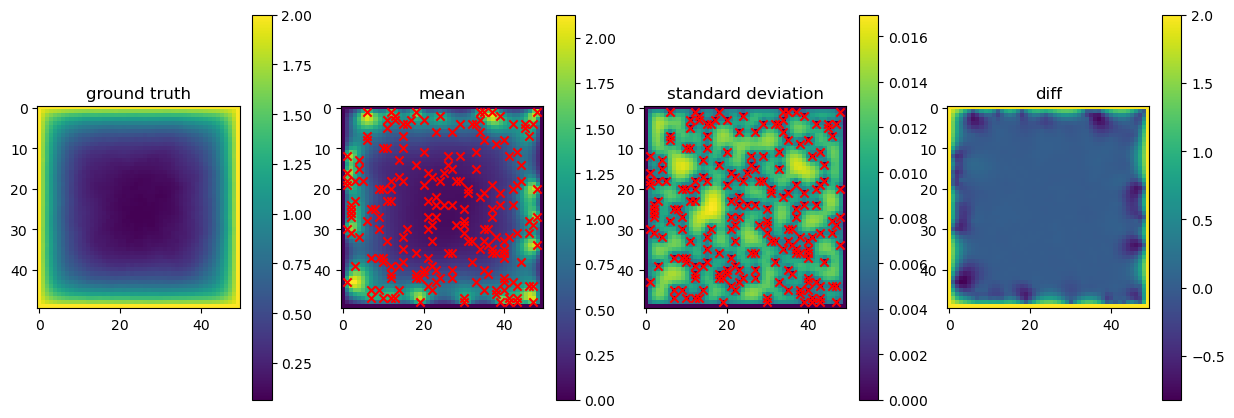

In [18]:
# Plot results
fig, axs = plt.subplots(1, 4, figsize=(15,5))
gtim = axs[0].imshow(u)
axs[0].set_title('ground truth')
fig.colorbar(gtim)
ptim = axs[1].imshow(posterior_mean)
axs[1].scatter(idxs[:,1], idxs[:,0], c='r', marker='x')
axs[1].set_title('mean')
fig.colorbar(ptim)
ptstdim = axs[2].imshow(posterior_std)
axs[2].scatter(idxs[:,1], idxs[:,0], c='r', marker='x')
axs[2].set_title('standard deviation')
fig.colorbar(ptstdim)
diffim = axs[3].imshow(u - posterior_mean)
axs[3].set_title('diff')
fig.colorbar(diffim)